In [86]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from mpl_toolkits.mplot3d import Axes3D
from salishsea_tools import viz_tools
from scipy.optimize import curve_fit

%matplotlib inline

In [8]:
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

### Build idealized basin, islands, and channels

In [41]:
# Build coordinates
j, i = bathy.Bathymetry.shape
x = np.arange(i)
y = np.arange(j)
x, y = np.meshgrid(x, y, indexing='xy')

# Make main basin
z = -1 * (np.cosh((x - 200)/12)*20 + np.cosh((y - 550)/35)) + 400

# Add Texada island
zz = z - 1000 * np.exp(-((x - 210)/10)**2 - ((y - 610)/40)**2)

# Add channel
zz = zz + 20000 * np.exp(-((x - 84.7)/33.1)**2 - ((y - 620)/15)**2)

# Add channel
zz = zz + 10000 * np.exp(-((x - 317)/40)**2 - ((y - 770)/8)**2)

# Add channel
zz = zz + 1200 * np.exp(-((x - 220)/10)**2 - ((y - 850)/50)**2)

# Add small island
zz = zz - 500 * np.exp(-((x - 158)/6)**2 - ((y - 620)/6)**2)

# Add small island
zz = zz - 500 * np.exp(-((x - 220)/6)**2 - ((y - 770)/6)**2)

# Trim negative points as land
z[z < 0] = 0
zz[zz < 0] = 0

### Visualize
**Cross-section**

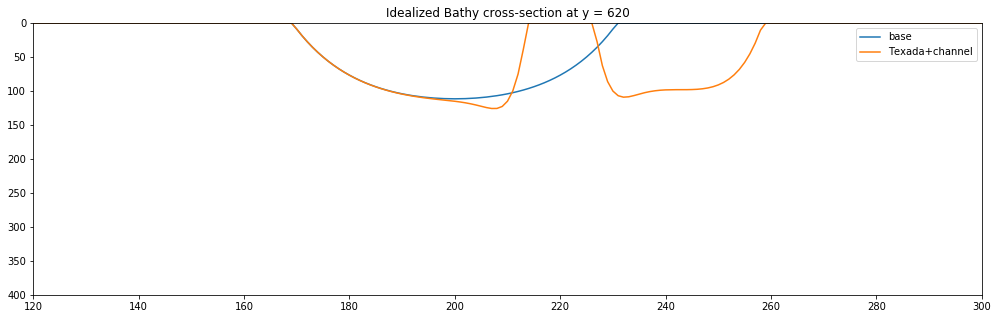

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(z[770, :], label='base')
ax.plot(zz[770, :], label='Texada+channel')
ax.set_xlim([120, 300])
ax.set_ylim([400, 0])
ax.set_title('Idealized Bathy cross-section at y = 620')
ax.legend()

**Wire mesh**

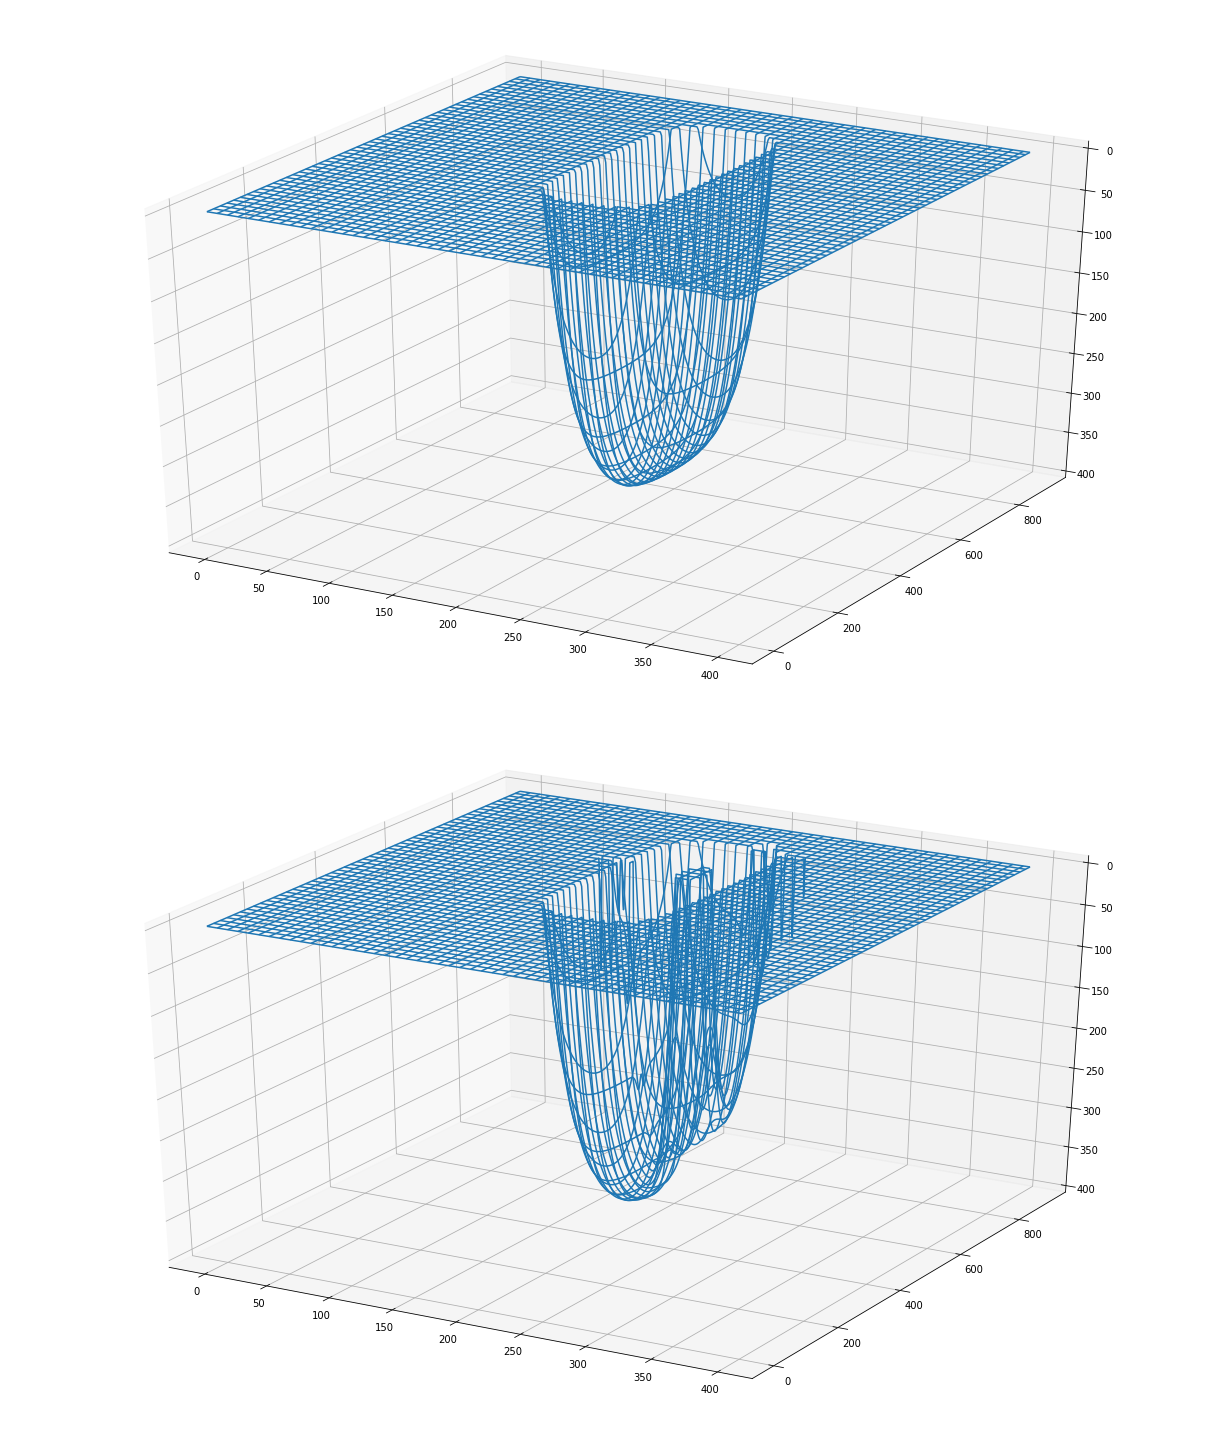

In [6]:
fig = plt.figure(figsize=(17, 20))
for col, Z in zip([1, 2], [z, zz]):
    ax = fig.add_subplot(2, 1, col, projection='3d')
    ax.plot_wireframe(x, y, Z)
    ax.set_zlim([400, 0])

fig.tight_layout()
plt.show()

**Plan view**

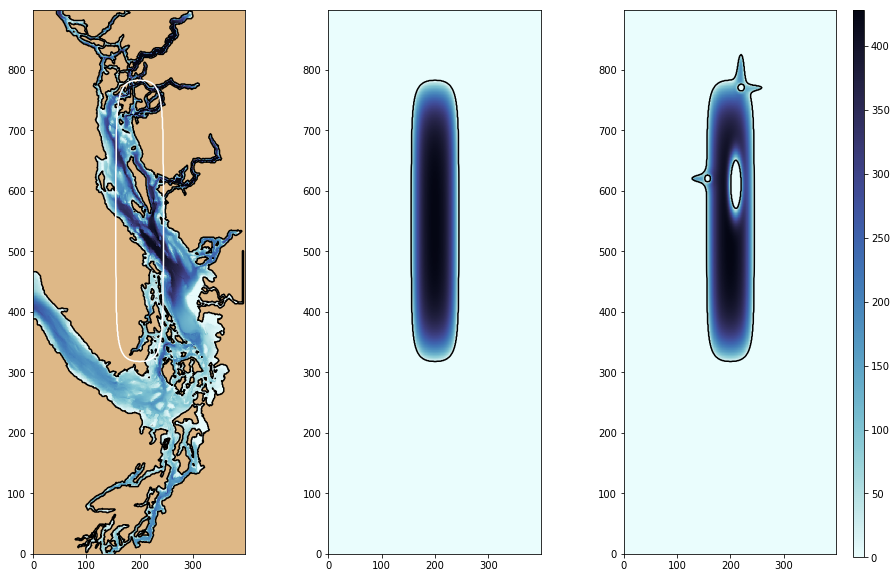

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
for ax in axs:
    ax.set_xlim([0, 398])
    ax.set_ylim([0, 898])
    viz_tools.set_aspect(ax)

c = axs[0].pcolormesh(bathy.Bathymetry, cmap=cmocean.cm.ice_r)
axs[0].contourf(bathy.Bathymetry, levels=[-0.01, 0.01], colors='burlywood')
axs[0].contour(bathy.Bathymetry, levels=[-0.01, 0.01], colors='k')
axs[0].contour(z, levels=1, colors='w')

axs[1].pcolormesh(z, cmap=cmocean.cm.ice_r)
axs[1].contour(z, levels=1, colors='k')

axs[2].pcolormesh(zz, cmap=cmocean.cm.ice_r)
axs[2].contour(zz, levels=1, colors='k')

cax = fig.add_axes([0.9, 0.12, 0.01, 0.76])
fig.colorbar(c, cax=cax)

### Save new pond bathy to netCDF

In [6]:
# Define subdomain lims
xrange = [127, 260]
yrange = [315, 827]

# Update bathy field and grid and save to netCDF
#bathy.update({'Bathymetry': (['y', 'x'], zz)}).isel(y=slice(*yrange), x=slice(*xrange)).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/bathymetry_pond_all.nc')
#grid.isel(y=slice(*yrange), x=slice(*xrange)).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/coordinates_seagrid_pond.nc', engine='scipy')

### Initial strat

In [217]:
def expfit(z, a, b, c, d):
    return a * np.exp(-b * z) + c * z + d

In [215]:
def rho_from_N2(z, a, b, c, d):
    return a / b * (1 - np.exp(-b * z)) + c / 2 * z**2 + d * z

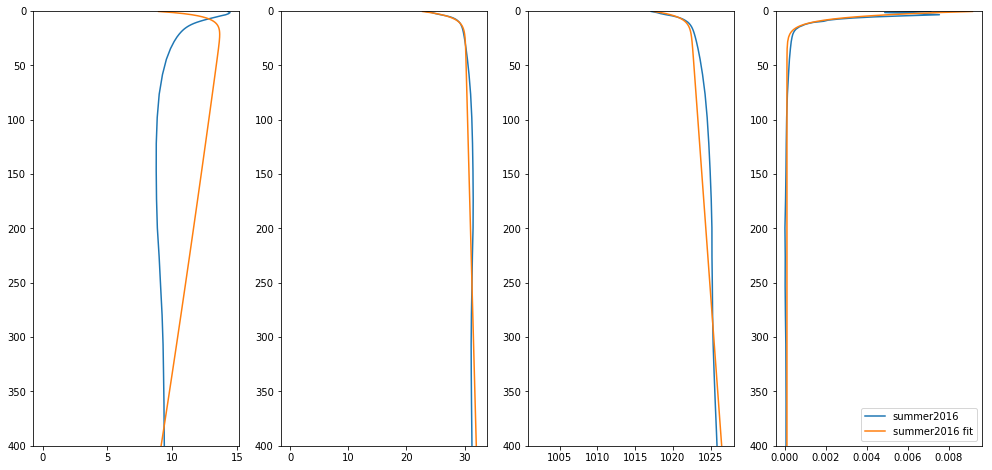

In [233]:
g = -9.81
rho_0 = 1030

raw = {'summer2016': {}, 'winter2017': {}}

fits = {
    'summer2016': {
        'params': {
            'SA': (-8, 1/5, 5e-3, 30),
            'N2': (0.01, 1/5, 0, 1e-4),
            'rho_surf': 1017.0,
        },
    },
    'winter2017': {
        'params': {
            'SA': (-3, 1/10, 5e-3, 30),
            'N2': (0.003, 1/7, -1e-7, 1e-4),
            'rho_surf': 1020.0,
        },
    },
}

fig, axs = plt.subplots(1, 4, figsize=(17, 8))

for season in ['summer2016']:

    data = xr.open_dataset(f'/data/bmoorema/MEOPAR/tracers/initial/{season}_201702.nc')
    z = data.deptht
    raw[season]['SA'] = np.ma.masked_values(data.vosaline, 0).mean(axis=(1, 2)).data
    raw[season]['CT'] = np.ma.masked_values(data.votemper, 0).mean(axis=(1, 2)).data
    raw[season]['rho'] = gsw.rho(raw[season]['SA'], raw[season]['CT'], z)
    raw[season]['N2'] = -g / rho_0 * np.diff(raw[season]['rho']) / np.diff(z)
    N2_deep = raw[season]['N2'][-2]
    raw[season]['N2'] = np.append(raw[season]['N2'][:-1], [N2_deep, N2_deep])
    
    fits[season]['SA'] = expfit(z, *fits[season]['params']['SA'])
    fits[season]['N2'] = expfit(z, *fits[season]['params']['N2'])
    fits[season]['rho'] = -rho_0 / g * rho_from_N2(z, *fits[season]['params']['N2']) + fits[season]['params']['rho_surf']
    fits[season]['CT'] = gsw.CT_from_rho(fits[season]['rho'], fits[season]['SA'], z)[0]
    
    for ax, key in zip(axs, ['CT', 'SA', 'rho', 'N2']):
        ax.plot(raw[season][key], z, label=season)
        ax.plot(fits[season][key], z, label=f'{season} fit')
        ax.set_ylim([400, 0])
        
axs[3].legend()

### Results

In [34]:
T = xr.open_dataset('/data/bmoorema/MEOPAR/Results/SalishSeaLake_1h_20170601_20170604_ptrc_T.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/Results/mesh_mask.nc')

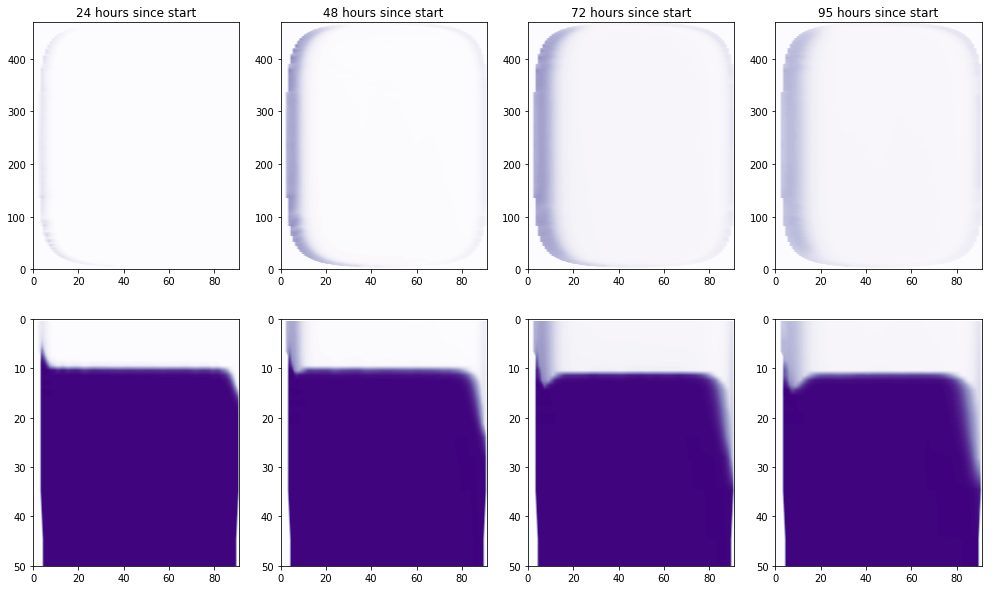

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(17, 10))

for ax, t in zip(axs[0, :], [24, 48, 72, 95]):
    c = ax.contourf(T.mytracer1[t, 0, ...], levels=np.arange(0, 1.02, 0.01), cmap="Purples")
    ax.set_title(f'{t} hours since start')
    
for ax, t in zip(axs[1, :], [24, 48, 72, 95]):
    c = ax.contourf(T.x, T.deptht, T.mytracer1[t, :, 250, :], levels=np.arange(0, 1.02, 0.01), cmap="Purples")
    ax.set_ylim([50, 0])

#fig.colorbar(c)